<a href="https://colab.research.google.com/github/Riddars/ITMO_Project_Cytotoxic/blob/%D0%A1%D0%BE%D0%B7%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8/Final_LazyPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.4 MB/s eta 0:00:00


In [2]:
FullDf = pd.read_csv('/content/filtered_dataset_All_Decription.csv', encoding='ISO-8859-1')


In [ ]:
FullDf.head()

,Cell type,test,material,time (hr),concentration (ug/ml),viability (%),Hydrodynamic diameter (nm),Zeta potential (mV),CID,Canonical Smiles,...,kappa3,Phi,Canonical Smiles.1,cell line,organism,cell type,morphology,tissue,disease,BSL
0,143B,MTT,Au,4,200.0,36.126,24.6,-4.65,23985,[Au],...,2.143769,0.158602,[Au],143B,Human,Human,mix,bone,osteosarcoma,1
1,143B,MTT,Au,4,400.0,22.253,24.6,-33.33,23985,[Au],...,2.143769,0.158602,[Au],143B,Human,Human,mix,bone,osteosarcoma,1
2,143B,MTT,Au,4,500.0,19.643,24.6,-31.30,23985,[Au],...,2.143769,0.158602,[Au],143B,Human,Human,mix,bone,osteosarcoma,1
3,143B,MTT,Au,72,1.0,91.262,24.6,-16.95,23985,[Au],...,2.143769,0.158602,[Au],143B,Human,Human,mix,bone,osteosarcoma,1
4,143B,MTT,Au,72,3.0,87.500,24.6,29.45,23985,[Au],...,2.143769,0.158602,[Au],143B,Human,Human,mix,bone,osteosarcoma,1


Лишние столбцы дубликаты

In [3]:
# Список столбцов, которые нужно удалить
columns_to_drop = ['cell line', 'cell type']

# Удаление столбцов
df = FullDf.drop(columns_to_drop, axis=1)

Encoding

In [4]:
le = LabelEncoder()
text_data_features = ['Cell type', 'test', 'material', 'Canonical Smiles', 'Canonical Smiles.1', 'organism', 'morphology', 'tissue', 'disease']
l3 = []; l4 = [];
print('Label Encoder Transformation')
for i in tqdm(text_data_features):
    df[i] = le.fit_transform(df[i])
    l3.append(list(df[i].unique())); l4.append(list(le.inverse_transform(df[i].unique())))
    print(i,' : ',df[i].unique(),' = ',le.inverse_transform(df[i].unique()))

Label Encoder Transformation


100%|██████████| 9/9 [00:00<00:00, 181.97it/s]

Cell type  :  [ 0  1  2  3  4  5  6  7  8  9 10 13 11 12 14 15 16 28 17 18 19 20 21 22
 29 31 30 23 64 24 25 65 66 26 27 32 33 34 35 36 37 38 39 44 40 41 42 67
 43 45 68 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]  =  ['143B' '16HBE' '95D' 'A2780' 'A431' 'A549' 'AGS' 'Ana-1' 'BALB/c3T3'
 'C3A' 'C6' 'Caco-2' 'CCL-110' 'CHO-K1' 'EBF' 'EJ28' 'H1299' 'HaCat'
 'HCMEC' 'HCT-116' 'HDF' 'HEBC3-KT' 'HEK' 'HEK293' 'HeLa' 'Hepatocytes'
 'HepG2' 'HFL1' 'hFOB1.19' 'HGF' 'HK-2' 'hMSC' 'hPDLF' 'HT29' 'HUVEC'
 'IMR90' 'J774A.1' 'Jurkat' 'KEC' 'L-02' 'L-132' 'L929' 'Lymphocyte'
 'Macrophages' 'MCF-7' 'MDCK' 'MDCK-II' 'mDF' 'MG-63' 'Monocytes'
 'neuro2A' 'NHDF' 'NIH3T3' 'NR8383' 'PBMC' 'PC12' 'PK-15' 'RAW264.7'
 'RFPEC' 'SHSY5Y' 'SIRC' 'SKOV-3' 'THP-1' 'U87' 'UM-UC-3' 'V79' 'VERO'
 'WA09' 'WISH']
test  :  [ 9 10  1  3  8  7 11  0  4 12  2  6  5]  =  ['MTT' 'NRU' 'CCK-8' 'CellTiterBlue' 'MTS' 'Live/Dead' 'WST-1'
 'AlamarBlue' 'CellTiterGlo' 'XTT' 'CVS' 'LDH' 'CytoTox-Glo']
material  :  [ 1  9 

In [5]:
# Ваши данные и столбцы для нормализации
columns_to_normalize = ['time (hr)', 'concentration (ug/ml)', 'viability (%)', 'Hydrodynamic diameter (nm)', 'Zeta potential (mV)', 'CID', 'exactmw', 'amw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds', 'NumHBD', 'NumHBA', 'NumHeavyAtoms', 'NumAtoms', 'NumHeteroatoms', 'NumAmideBonds', 'FractionCSP3', 'NumRings', 'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings', 'NumHeterocycles', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles', 'NumSpiroAtoms', 'NumBridgeheadAtoms', 'NumAtomStereoCenters', 'NumUnspecifiedAtomStereoCenters', 'labuteASA', 'tpsa', 'CrippenClogP', 'CrippenMR', 'chi0v', 'chi1v', 'chi2v', 'chi3v', 'chi4v', 'chi0n', 'chi1n', 'chi2n', 'chi3n', 'chi4n', 'hallKierAlpha', 'kappa1', 'kappa2', 'kappa3', 'Phi', 'BSL']

# Получите минимальные и максимальные значения для каждого столбца до нормализации
min_values_before = df[columns_to_normalize].min()
max_values_before = df[columns_to_normalize].max()

print("Минимальные значения до нормализации:")
print(min_values_before)

print("Максимальные значения до нормализации:")
print(max_values_before)

Минимальные значения до нормализации:
time (hr)                            2.000000
concentration (ug/ml)                0.000000
viability (%)                        0.000000
Hydrodynamic diameter (nm)           1.150000
Zeta potential (mV)               -119.500000
CID                                935.000000
exactmw                             12.000000
amw                                 12.011000
lipinskiHBA                          0.000000
lipinskiHBD                          0.000000
NumRotatableBonds                    0.000000
NumHBD                               0.000000
NumHBA                               0.000000
NumHeavyAtoms                        1.000000
NumAtoms                             1.000000
NumHeteroatoms                       0.000000
NumAmideBonds                        0.000000
FractionCSP3                         0.000000
NumRings                             0.000000
NumAromaticRings                     0.000000
NumAliphaticRings                    0.000

Удаляю лишние дескрипторы.

In [6]:
# Список столбцов, которые нужно удалить
columns_to_drop = ['Canonical Smiles.1', 'chi4n', 'tpsa','chi3v','chi2n','NumRotatableBonds','chi4v','chi3n','chi2v','NumHBD','lipinskiHBD','NumAromaticRings','NumAliphaticRings','NumAmideBonds','FractionCSP3','NumUnspecifiedAtomStereoCenters','NumAtomStereoCenters', 'NumRings','NumAliphaticHeterocycles','NumSaturatedHeterocycles','NumAromaticHeterocycles','NumHeterocycles','NumSaturatedRings','NumSpiroAtoms']

# Удаление столбцов
df = df.drop(columns_to_drop, axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2865 entries, 0 to 2864
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cell type                   2865 non-null   int64  
 1   test                        2865 non-null   int64  
 2   material                    2865 non-null   int64  
 3   time (hr)                   2865 non-null   int64  
 4   concentration (ug/ml)       2865 non-null   float64
 5   viability (%)               2865 non-null   float64
 6   Hydrodynamic diameter (nm)  2865 non-null   float64
 7   Zeta potential (mV)         2865 non-null   float64
 8   CID                         2865 non-null   int64  
 9   Canonical Smiles            2865 non-null   int64  
 10  exactmw                     2865 non-null   float64
 11  amw                         2865 non-null   float64
 12  lipinskiHBA                 2865 non-null   float64
 13  NumHBA                      2865 

R-квадрат: 0.74
MSE: 238.64


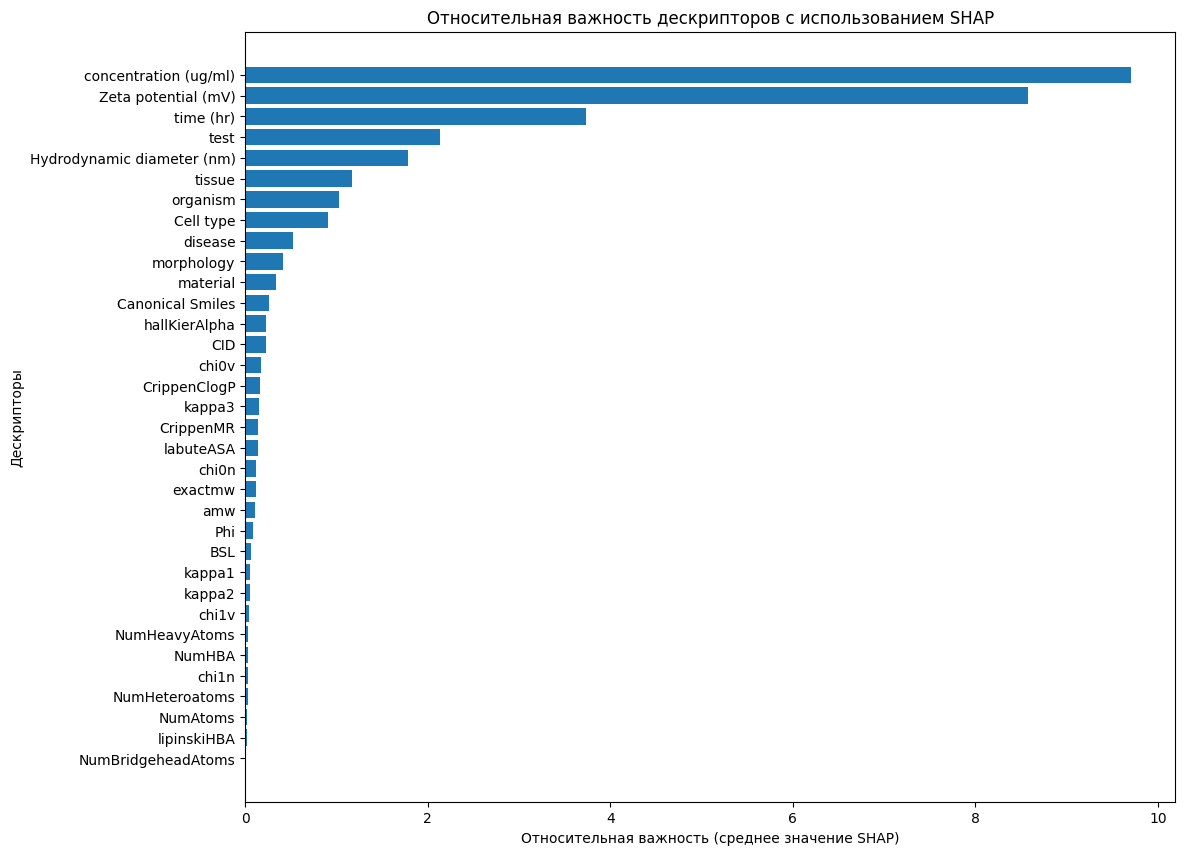

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Загрузите ваш фрейм данных (df) или создайте его, если он ещё не существует

X = df.drop(['viability (%)'], axis=1)
y = df['viability (%)']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация модели
model = RandomForestRegressor()

# Обучение модели
model.fit(X_train, y_train)

# Оценка R-квадрат и MSE на тестовых данных
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Вывод значений R-квадрат и MSE
print(f'R-квадрат: {r2:.2f}')
print(f'MSE: {mse:.2f}')

# Инициализация explainer SHAP для модели
explainer = shap.TreeExplainer(model)

# Получение значений SHAP для тестовых данных
shap_values = explainer.shap_values(X_test)

# Определение важности дескрипторов
importance = abs(shap_values).mean(axis=0)

# Создание DataFrame с важностью дескрипторов
importance_df = pd.DataFrame({
    'Descriptor': X.columns,
    'Importance': importance
})

# Сортировка по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Построение графика относительной важности дескрипторов
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Descriptor'], importance_df['Importance'])
plt.xlabel('Относительная важность (среднее значение SHAP)')
plt.ylabel('Дескрипторы')
plt.title('Относительная важность дескрипторов с использованием SHAP')
plt.gca().invert_yaxis()
plt.show()



---


